In [1]:
from fy3_l0 import parse

In [2]:
with open('data/Y3E_08897_230323231257_7860R_MERSI.DAT', 'rb') as file:
    obama = parse(file)

In [3]:
obama.header.scan_start

datetime.datetime(2023, 3, 23, 23, 12, 56)

In [5]:
dn_11_lines = []
for tb in obama.transport_blocks:
    dn_11_lines.extend([i.data for i in tb.dn_data_blocks[3].blocks])

In [6]:
import matplotlib.pyplot as plt

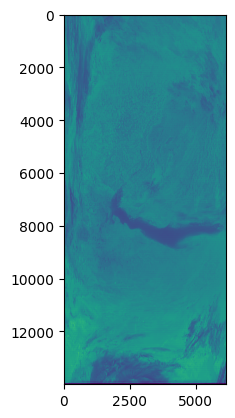

In [7]:
plt.imshow(dn_11_lines)